In [50]:
import json
import time
import datetime
import requests
import pybybit
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge

from config import get_config
from logic_funcs import feature_engineering, get_model, logic
from data_get_funcs import get_btc_ohlcv, get_depth, get_data
from bybit_funcs import get_position, market_order
from utils import discord_Notify



In [2]:
df = get_data()
df, feats = feature_engineering(df)
model = get_model(df, feats)
p = model.predict(df[feats].values[-1].reshape(1, -1))
print(p)

[21.48311748]


In [89]:
from bitmex import bitmex
def get_eth():
    config = get_config()
    bitmex_client = bitmex(test=False, api_key=config["bitmex_key"], api_secret=config["bitmex_secret"])
    symbol = "ETH"
    t = datetime.datetime.strptime("2018-8", "%Y-%M") ## これより過去は取れない
    df_eth = pd.DataFrame(bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize="1d", count=1000, reverse=False, startTime = t).result()[0])
    df_eth = df_eth[["timestamp", "open", "high", "low", "close", "trades", "volume", "vwap"]]
    df_eth = df_eth.add_suffix("_eth")
    df_eth["time"] = df_eth["timestamp_eth"].apply(lambda a : datetime.datetime.strptime(str(a).split("+")[0], "%Y-%m-%d  %H:%M:%S"))
    return df_eth

In [187]:

def get_data():
    data = get_btc_ohlcv()
    dep = get_depth()
    df = data.merge(dep)
    eth = get_eth()
    df = df.merge(eth, on = "time")
    feats = ["time", "close", "open", "high", "low", "volume",
    "asks5", "bids5", "asks10", "bids10", "asks20", "bids20", "asks30", "bids30", "asks50", "bids50", "asks90", "bids90"]
    feats += ["open_eth", "high_eth", "low_eth", "close_eth", "trades_eth", "volume_eth", "vwap_eth"]
    df = df[feats]
    return df


In [188]:
df = get_data()
pd.to_pickle(df, "data.pkl")

In [189]:
df.tail()

,time,close,open,high,low,volume,asks5,bids5,asks10,bids10,asks20,bids20,asks30,bids30,asks50,bids50,asks90,bids90
1243,2020-08-08,11773.0,11600.0,11822.0,11530.0,1087906266,1.008333e+08,1.213821e+08,1.163569e+08,1.985518e+08,1.317998e+08,2.735756e+08,1.163569e+08,1.985518e+08,1.463356e+08,3.960148e+08,1.163569e+08,1.985518e+08
1244,2020-08-09,11691.0,11773.0,11821.5,11532.5,1015369966,1.005250e+08,1.370054e+08,1.263499e+08,2.165061e+08,1.401683e+08,2.894386e+08,1.263499e+08,2.165061e+08,1.534610e+08,4.113668e+08,1.263499e+08,2.165061e+08
1245,2020-08-10,11900.5,11691.0,12110.0,11435.5,2411212574,7.910596e+07,1.177671e+08,9.762097e+07,1.852374e+08,1.208919e+08,2.674734e+08,9.762097e+07,1.852374e+08,1.328587e+08,3.967796e+08,9.762097e+07,1.852374e+08
1246,2020-08-11,11383.0,11900.5,11949.5,11125.0,2816090978,8.825701e+07,1.329731e+08,1.119124e+08,2.127327e+08,1.380041e+08,2.711745e+08,1.119124e+08,2.127327e+08,1.532228e+08,3.971043e+08,1.119124e+08,2.127327e+08
1247,2020-08-12,11570.5,11383.0,11619.5,11078.5,1516495486,1.024324e+08,1.291242e+08,1.228747e+08,2.300548e+08,1.506265e+08,2.849673e+08,1.228747e+08,2.300548e+08,1.663458e+08,4.106024e+08,1.228747e+08,2.300548e+08


In [186]:
df.tail()

,time,close,open,high,low,volume,asks5,bids5,asks10,bids10,asks20,bids20,asks30,bids30,asks50,bids50,asks90,bids90,open_eth,high_eth,low_eth,close_eth,trades_eth,volume_eth,vwap_eth
740,2020-08-08,11773.0,11600.0,11822.0,11530.0,1087906266,1.008333e+08,1.213821e+08,1.163569e+08,1.985518e+08,1.317998e+08,2.735756e+08,1.163569e+08,1.985518e+08,1.463356e+08,3.960148e+08,1.163569e+08,1.985518e+08,395.25,399.00,362.0,379.95,136606,137073587,382.64
741,2020-08-09,11691.0,11773.0,11821.5,11532.5,1015369966,1.005250e+08,1.370054e+08,1.263499e+08,2.165061e+08,1.401683e+08,2.894386e+08,1.263499e+08,2.165061e+08,1.534610e+08,4.113668e+08,1.263499e+08,2.165061e+08,379.95,398.05,376.5,397.65,91994,73934191,387.59
742,2020-08-10,11900.5,11691.0,12110.0,11435.5,2411212574,7.910596e+07,1.177671e+08,9.762097e+07,1.852374e+08,1.208919e+08,2.674734e+08,9.762097e+07,1.852374e+08,1.328587e+08,3.967796e+08,9.762097e+07,1.852374e+08,397.65,401.20,384.4,390.70,91456,72424760,392.25
743,2020-08-11,11383.0,11900.5,11949.5,11125.0,2816090978,8.825701e+07,1.329731e+08,1.119124e+08,2.127327e+08,1.380041e+08,2.711745e+08,1.119124e+08,2.127327e+08,1.532228e+08,3.971043e+08,1.119124e+08,2.127327e+08,390.70,402.95,383.2,396.20,106685,103482364,395.58
744,2020-08-12,11570.5,11383.0,11619.5,11078.5,1516495486,1.024324e+08,1.291242e+08,1.228747e+08,2.300548e+08,1.506265e+08,2.849673e+08,1.228747e+08,2.300548e+08,1.663458e+08,4.106024e+08,1.228747e+08,2.300548e+08,396.20,398.90,367.1,378.85,135083,134549630,384.09


In [176]:

def feature_engineering(df):
#     df = pd.read_pickle("data.pkl")
    df["target"] = df["close"].diff().shift(-1)
    df["baseline"] = (df["close"] - df["open"]).shift(1) > 0
    
    df["feature_c-o"] = (df["close"] - df["open"])
    df["feature_h-c"] = (df["high"] - df["close"])
    df["feature_l-c"] = (df["low"] - df["close"])
    df["feature_h-o"] = (df["high"] - df["open"])
    df["feature_l-o"] = (df["low"] - df["open"])
    df["feature_h-l"] = (df["high"] - df["low"])

    feats = ["feature_c-o", "feature_h-c", "feature_l-c", "feature_h-o", "feature_l-o", "feature_h-l"]
    for shift in range(1, 3):
        for f in feats:
            df[f + f"_shift_{shift}"] = df[f].shift(shift)
    feats = [c for c in df.columns if "feature" in c]
    for f in feats:
        for rol in [7, 14]:
            df[f"{f}_vs_roll{rol}"] = df[f] > (df[f].rolling(rol).agg("mean"))
            
    df["feature_c-o_eth"] = (df["close_eth"] - df["open_eth"])
    df["feature_h-c_eth"] = (df["high_eth"] - df["close_eth"])
    df["feature_l-c_eth"] = (df["low_eth"] - df["close_eth"])
    df["feature_h-o_eth"] = (df["high_eth"] - df["open_eth"])
    df["feature_l-o_eth"] = (df["low_eth"] - df["open_eth"])
    df["feature_h-l_eth"] = (df["high_eth"] - df["low_eth"])

    feats = ["feature_c-o_eth", "feature_h-c_eth", "feature_l-c_eth", "feature_h-o_eth", "feature_l-o_eth", "feature_h-l_eth"]
    for f in feats:
        for rol in [7, 14]:
            df[f"{f}_vs_roll{rol}"] = df[f] > (df[f].rolling(rol).agg("mean"))
    for shift in range(1, 3):
        for f in feats:
            df[f + f"_shift_{shift}"] = df[f].shift(shift)
            
            
    for dep in [20, 30, 50, 90]:
        df[f"features_bid-ask{dep}"] = df[f"bids{dep}"] - df[f"asks{dep}"]
        for rol in [7, 14]:
            df[f"features_bid-ask{dep}_vs_roll{rol}"] = df[f"features_bid-ask{dep}"] > (df[f"features_bid-ask{dep}"].rolling(rol).agg("mean"))
        df[f"features_bid-ask{dep}"] = df[f"features_bid-ask{dep}"] > 0
    dep_cols = [c for c in df.columns if "ask" in c or "bid" in c and "feature" in c]
    for shift in range(1, 2):
        for c in dep_cols:
            df[c + f"_shift_{shift}"] = df[c].shift(shift)

    feats = [c for c in df.columns if "feature" in c]# + dep_shifts_cols
    
    for k in range(7):
        df[f"feature_dow_{k}"] = df.index % 7 == k
    
    df["feature_dow"] = df["feature_dow_0"] + df["feature_dow_2"] + df["feature_dow_5"]
    
    for f in feats:
        df[f] = df[f] > 0
#     print(len(feats))
#     evaluate(df, feats)
    
    return df, feats

In [177]:
from scipy import optimize
from functools import partial

class Opt():
    def __init__(self):
        pass
    
    def fit(self, x, y):
        func = partial(self.eval_func, x = x, y = y, lam = 1)
        w = np.zeros(x.shape[1] + 1)
        w_opt = optimize.fmin(func, w)
        self.w_opt = w_opt
        
    def eval_func(self, w, x, y, lam = 0):
        p = np.dot(x, w[:-1]) + w[-1]
        y_ = y.copy()
        y_[p<=0] *= -1
        score = np.sum(y_)
        reg = np.sum(np.abs(w)) * lam
        score = score - reg
        return -score
    
    def predict(self, x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return np.array(x.dot(self.w_opt[:-1]) + self.w_opt[-1])


class Model():
    def __init__(self, th = 200, mean_subtract = False):
        self.th = th
        self.mean_subtract = mean_subtract
        self.models = [
            Ridge(100),
            LGBMRegressor(max_depth=5, colsample_bytree=0.9, subsample=0.9,
                      subsample_freq=1, reg_alpha = 1, reg_lambda = 1, min_split_gain=1),
            SVR(),
#             MLPRegressor(hidden_layer_sizes=(16))
        ]
        self.weights = [1/40, 1/150, 1/4]#, 1/50]
    def fit(self, x, y):
        y = np.clip(y, -self.th, self.th)
        if self.mean_subtract:
            y = y - np.mean(y)
        for model in self.models:
            model.fit(x, y)
    def predict(self, x):
        p = 0
        for model, w in zip(self.models, self.weights):
            p_ = model.predict(x) * w
            print(np.min(p_), np.median(p_), np.max(p_))
            p += p_
        return p

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def evaluate(df, feats, t):
    for f in feats:
        df[f] = df[f].astype(np.float32)

    df = df[feats + ["time", "target", "baseline"]][df[feats].isna().sum(axis = 1) == 0]
    train = df[df["time"] < datetime.datetime.strptime(t, '%Y-%m-%d')].reset_index(drop = True)
    test = df[df["time"] >= datetime.datetime.strptime(t, '%Y-%m-%d')].reset_index(drop = True)
    train[feats] = train[feats].fillna(train[feats].mean())
    print(train.shape, test.shape)
    
#     model = Ridge(5000)

    model = Model(th = 200, mean_subtract = True)
    model.fit(train[feats], train["target"])
#     model.fit(train[feats], np.clip(train["target"], -th, th) > 0, sample_weight = np.abs(train["target"]))
    
#     fi = pd.DataFrame()
#     fi["name"] = feats
#     fi["coef"] = model.coef_.flatten()
#     fi["coef_abs"] = np.abs(fi["coef"])
#     fi = fi.sort_values(by = "coef_abs", ascending = False)
#     plt.figure(figsize = (8, 14))
#     sns.barplot(data = fi, x = "coef", y = "name")
#     plt.show()
    
    p = model.predict(test[feats])# - 0.5
    corr = np.corrcoef(test["target"], p)[0,1]
    
    for df in [train, test]:
        p = model.predict(df[feats])# - 0.5
        df["rev"] = df["target"].copy()
        plt.plot(df["rev"].cumsum(), label = "cumsum")

        
        
        goods = ["feature_c-o_shift_1", "features_bid-ask20_vs_roll14", "features_bid-ask90_vs_roll14_shift_1"]
        for good in goods:
            df["rev"] = df["target"].copy()
            df.loc[df[good] == False, "rev"] *= -1
            plt.plot(df["rev"].cumsum(), label = good)
        
        goods = ["feature_c-o_eth_shift_1", "feature_dow"]
        for good in goods:
            df["rev"] = df["target"].copy()
            df.loc[df[good] == True, "rev"] *= -1
            plt.plot(df["rev"].cumsum(), label = good)
        
        df["p"] = (df["features_bid-ask20_vs_roll14"] == True) * 1 + (df["feature_c-o_shift_1"] == True) +\
        (df["feature_c-o_eth_shift_1"] == False) / 3

        df["rev"] = df["target"].copy()
        df.loc[df["p"] < 0.5, "rev"] *= -1
        plt.plot(df["rev"].cumsum(), "--", label = "rule")

        
        df["rev"] = df["target"].copy()
        th = 0
        df.loc[p < -th, "rev"] *= -1
#         df.loc[(p > 0) != (df["baseline"]), "rev"] = 0
        df.loc[np.abs(p) < th, "rev"] *= 0
        plt.plot(df["rev"].cumsum(), label = "ml")
        plt.legend()
        plt.show()
        
    print(np.sum(test["rev"]))
    return corr

/opt/conda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


116
(519, 119) (224, 119)
-1.583487949622828 0.07138782997263866 1.6890674205877376
-0.9940509675438707 0.011371913361532314 1.016603957341006
-0.6093471927769023 0.16030078033650766 1.0615328973251776
-1.6495369303573852 0.015911086401556942 1.9198854488831447
-1.2283697765251962 0.014587620195945996 1.264095909080793
-0.655652961868284 0.08995024762470527 1.0045554766986213


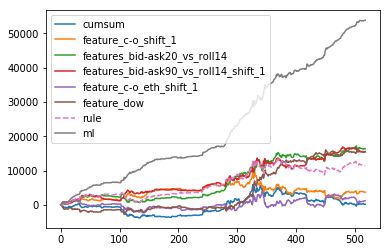

-1.583487949622828 0.07138782997263866 1.6890674205877376
-0.9940509675438707 0.011371913361532314 1.016603957341006
-0.6093471927769023 0.16030078033650766 1.0615328973251776


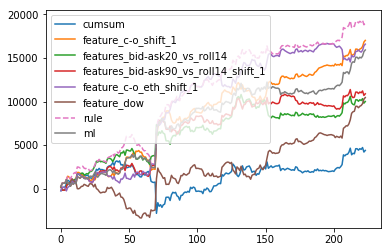

15922.5


0.15966412160733243

In [183]:
import seaborn as sns
df = pd.read_pickle("data.pkl")
df, feats = feature_engineering(df)
df = df[df.isna().sum(axis = 1) == 0].reset_index(drop = True)
feats = [c for c in df.columns if "feature" in c]# + dep_shifts_cols
print(len(feats))

# t = "2019-01-01"
# t = "2019-03-01"
# t = "2019-06-01"
# t = "2019-09-01"
t = "2020-01-01"
# t = "2020-04-01"
evaluate(df, feats, t)

In [72]:
def eval_func(w, x, y, lam = 0):
    p = np.dot(x, w[:-1]) + w[-1]
    y_ = y.copy()
    y_[p<=0] *= -1
    score = np.sum(y_)
    reg = np.sum(np.abs(w)) * lam
    score = score - reg
    return -score


In [73]:
scores = []
for k in range(len(feats)):
    w = np.zeros(len(feats) + 1)
    w[k] = 1
    score = eval_func(w, df[feats], df["target"])
    scores.append(-score)

In [74]:
d = pd.DataFrame()
d["name"] = feats
d["score"] = scores

In [75]:
d.sort_values(by = "score")

,name,score
72,feature_c-o_eth_shift_1,-17741.0
108,feature_dow_0,-14622.0
18,feature_c-o_vs_roll7,-12747.0
0,feature_c-o,-11810.0
64,feature_l-c_eth_vs_roll7,-11504.0
19,feature_c-o_vs_roll14,-11500.0
35,feature_l-c_shift_1_vs_roll14,-11320.0
113,feature_dow_5,-10339.0
110,feature_dow_2,-10052.0
50,feature_l-o_shift_2_vs_roll7,-9893.0


In [175]:
d[d["name"].apply(lambda x : "dow" in x)]

,name,score
108,feature_dow_0,-14622.0
109,feature_dow_1,6669.0
110,feature_dow_2,-10052.0
111,feature_dow_3,-1894.0
112,feature_dow_4,-2947.0
113,feature_dow_5,-10339.0
114,feature_dow_6,10360.0
